In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
import seaborn as sns

In [28]:
df = pd.read_csv("encoded_loan_data.csv", sep=',', engine='python', error_bad_lines=False, dtype='unicode')

Before visualizing this data we must ensure all processed data is numeric. 
<font color='red'>This will be more meaningful after enums. Added the following until we fix export to csv from pre-processing</font> 

In [29]:
colToType = {
    "tract_to_msamd_income" : float, 
    "rate_spread" : float,
    "population" : int,
    "minority_population" : bool,
    "number_of_owner_occupied_units" : int, 
    "number_of_1_to_4_family_units" : int, 
    "loan_amount_000s" : float, 
    "hud_median_family_income" : float,
    "applicant_income_000s" : float,
    "sequence_number" : int, 
    "census_tract_number" : float, 
    "as_of_year" : int,
    "application_date_indicator" : int,     
}

In [30]:
df_test = df
# Use Pandas drop_duplicates() as evidence that dataset is deduplicated
print("Deduplicated Valid Rows: %d\tFully Deduplicated: %r" 
      % (len(df_test), len(df_test) == len(df_test.drop_duplicates())))
print("Columns: %d" % len(df_test.columns.values))

# Convert types of columns
for colName, colType in colToType.items():
    if colType == int:
        df_test[colName] = df_test[colName].apply(lambda x: x if x != 'nan' else 0).astype(int)
    if colType == float:
        df_test[colName] = df_test[colName].apply(lambda x: x if x != 'nan' else float('nan')).astype(float)

Deduplicated Valid Rows: 371894	Fully Deduplicated: True
Columns: 48


In [31]:
numeric_cols = df_test.columns

In [32]:
assert [col in ['int64','float'] for col in [df[y].dtype for y in numeric_cols]]

In [33]:
df.applicant_race_name_1.value_counts()

White                                        240919
Not applicable                                45102
nan                                           36367
Black or African American                     23676
Asian                                         23438
American Indian or Alaska Native               1351
Native Hawaiian or Other Pacific Islander      1041
Name: applicant_race_name_1, dtype: int64

In [34]:
# bucketing can't stay if we want to use plot function, need numeric data
df["income_bracket"] = df["income_bracket"].replace('(0, 18]', 1)
df["income_bracket"] = df["income_bracket"].replace('(18, 75]', 2)
df["income_bracket"] = df["income_bracket"].replace('(75, 153]', 3)
df["income_bracket"] = df["income_bracket"].replace('(153, 233]', 4)
df["income_bracket"] = df["income_bracket"].replace('(233, 416]', 5)
df["income_bracket"] = df["income_bracket"].replace('(416, 470]', 6)
df["income_bracket"] = df["income_bracket"].replace('(470, 9999]', 7)
df["income_bracket"] = df["income_bracket"].replace('nan', -1)

In [35]:
#temporary. Need to retain changes from pre-processing somehow
df["income_bracket"] = df["income_bracket"].astype('float')
df["action_taken_name"] = df["action_taken_name"].astype('float')


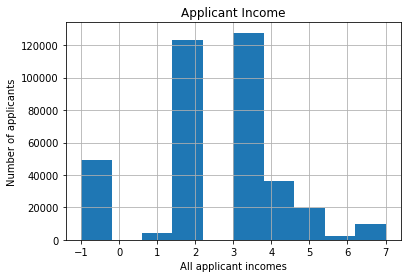

In [36]:
# applicant income histogram
df.income_bracket.hist()
plt.title('Applicant Income')
plt.xlabel('All applicant incomes')
plt.ylabel('Number of applicants')
plt.show()

In [37]:
df[df.applicant_race_name_1== "American Indian or Alaska Native"].groupby('income_bracket').action_taken_name.count()

income_bracket
-1.0    134
 1.0     42
 2.0    582
 3.0    452
 4.0     89
 5.0     31
 6.0      5
 7.0     16
Name: action_taken_name, dtype: int64

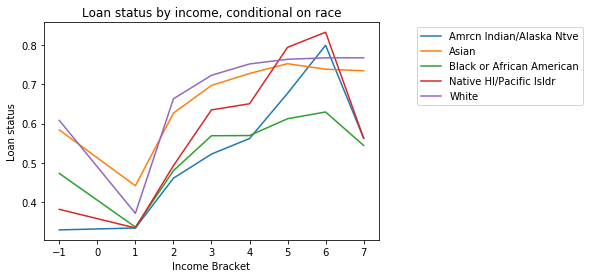

In [63]:
fig = plt.figure()
ax = plt.subplot(111)
df[df.applicant_race_name_1== "American Indian or Alaska Native"].groupby('income_bracket').action_taken_name.mean().plot()
df[df.applicant_race_name_1=="Asian"].groupby('income_bracket').action_taken_name.mean().plot()
df[df.applicant_race_name_1=="Black or African American"].groupby('income_bracket').action_taken_name.mean().plot()
df[df.applicant_race_name_1=="Native Hawaiian or Other Pacific Islander"].groupby('income_bracket').action_taken_name.mean().plot()
#df[df.applicant_race_name_1=="Not applicable"].groupby('income_bracket').action_taken_name.mean().plot()
df[df.applicant_race_name_1=="White"].groupby('income_bracket').action_taken_name.mean().plot()
plt.title('Loan status by income, conditional on race')
plt.xlabel('Income Bracket')
plt.ylabel('Loan status')
# plt.legend(['Amrcn Indian/Alaska Ntve', 'Asian', 'Black or African American'
#            ,'Native HI/Pacific Isldr','White'], loc='upper left')
ax.legend(['Amrcn Indian/Alaska Ntve', 'Asian', 'Black or African American'
           ,'Native HI/Pacific Isldr','White'], bbox_to_anchor=(1.1, 1.0))
#plt.legend(['Asian', 'Black or African American','White'], loc='upper right')
plt.show()

Looking at the mean number of application results for each race, we see for any income bracket, aside from one of the higher income brackets, there is a consistent discrepancy between loan status and race. Black or African American applicants were denied loan applications more frequently than white applicants. The amount by which the number of applicants with originated loans differ, is inconsistent between different races and across different income brackets.

The number of Native Hawaiian or Other Pacific Islander and American Indian applicants is low. As a result the confidence intervals for the following plot will be too large in order to gauage meaningful analyses with regards to race and application status?

In [40]:
#Loan status proportions and counts by applicant race and income bracket.
p_afram = df[df.applicant_race_name_1== "Black or African American"].groupby('income_bracket').action_taken_name.mean()
n_afram = df[df.applicant_race_name_1== "Black or African American"].groupby('income_bracket').action_taken_name.count()

p_white = df[df.applicant_race_name_1== "White"].groupby('income_bracket').action_taken_name.mean()
n_white = df[df.applicant_race_name_1== "White"].groupby('income_bracket').action_taken_name.count()

p_asian = df[df.applicant_race_name_1== "Asian"].groupby('income_bracket').action_taken_name.mean()
n_asian = df[df.applicant_race_name_1== "Asian"].groupby('income_bracket').action_taken_name.count()


In [49]:
n_afram

income_bracket
-1.0    2551
 1.0     441
 2.0    9151
 3.0    9557
 4.0    1426
 5.0     387
 6.0      27
 7.0     136
Name: action_taken_name, dtype: int64

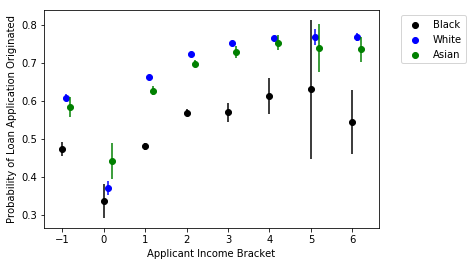

In [52]:
#Plot the proportions with 1-SD error bars
fig = plt.figure()
ax = plt.subplot(111)
x = np.arange(-1,7)
sd_afram = 1.96*np.sqrt(p_afram*(1-p_afram)/n_afram)
plt.vlines( x, p_afram+sd_afram, p_afram-sd_afram, color='black')
a = plt.scatter( x, p_afram, color='black', label="Black")

sd_white = 1.96*np.sqrt(p_white*(1-p_white)/n_white)
plt.vlines( x+.1, p_white+sd_white, p_white-sd_white, color='blue')
b = plt.scatter( x+.1, p_white, color='blue', label="White")

sd_asian = 1.96*np.sqrt(p_asian*(1-p_asian)/n_asian)
plt.vlines( x+.2, p_asian+sd_asian, p_asian-sd_asian, color='green')
b = plt.scatter( x+.2, p_asian, color='green', label="Asian")

plt.ylabel('Probability of Loan Application Originated')
plt.xlabel('Applicant Income Bracket')
# plt.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

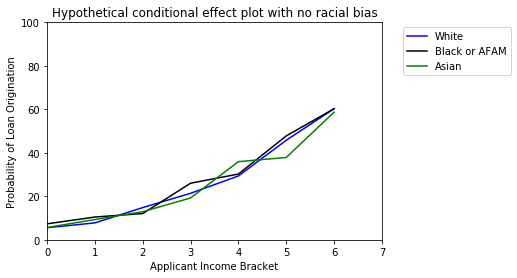

In [58]:
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effect plot with no racial bias")
plt.ylabel('Probability of Loan Origination')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,max(X) + 1)
plt.ylim(0,100)
# plt.legend(["White", "Black or AFAM", "Asian"], loc='upper right')
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()

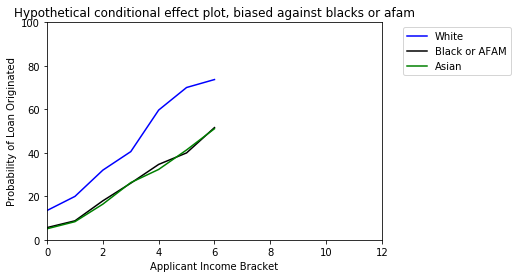

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
plt.plot(X, 100/(1+np.exp(.5*(3-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effect plot, biased against blacks or afam")
plt.ylabel('Probability of Loan Originated')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,12)
plt.ylim(0,100)
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()

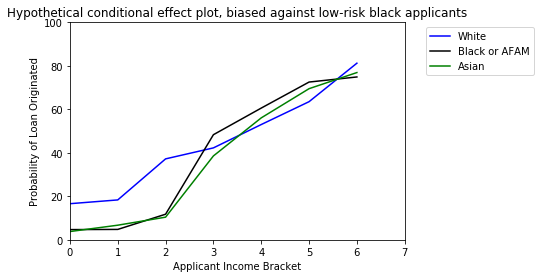

In [60]:
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
#what is X2 numbers probably aren't right for this
X2 = np.array([1,1,1,1,0,0,0,0,])
plt.plot(X, 100/(1+np.exp(.5*(3-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(3-X+3*X2+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(3-X+3*X2+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effect plot, biased against low-risk black applicants")
plt.ylabel('Probability of Loan Originated')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,max(X) + 1)
plt.ylim(0,100)
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()

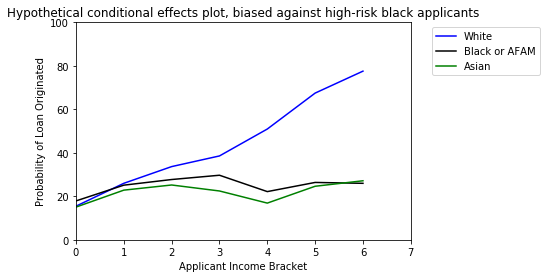

In [61]:
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
#what is X2 numbers probably aren't right for this
X2 = np.array([0,0,0,.2,.4,.8,1,1.2,])
plt.plot(X, 100/(1+np.exp(.5*(3-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(3-X+4*X2+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(3-X+4*X2+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effects plot, biased against high-risk black applicants")
plt.ylabel('Probability of Loan Originated')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,max(X) + 1)
plt.ylim(0,100)
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()